In [48]:
import numpy as np
import pandas as pd
import copy
import os

from fastai.vision.all import *
from fastai.text.all import *
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

import torchtext
from torchtext.data import get_tokenizer
from collections import Counter

import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
import PIL
from PIL import Image

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from evaluate import load

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [50]:
captions_path = "./train.csv"
images_path = "./train/"

In [51]:
df = pd.read_csv(captions_path)
print(len(df))
df.head()

74565


,img_name,img_path,mos,comments
0,41wy7upxzl,./train/41wy7upxzl.jpg,5.569231,"the pink and blue really compliment each other. like the dense color, blur."
1,ygujjq6xxt,./train/ygujjq6xxt.jpg,6.103175,love rhubarb! great colors!
2,wk321130q0,./train/wk321130q0.jpg,5.541985,i enjoy the textures and grungy feel to this. i also really like the deep rich red color.
3,w50dp2zjpg,./train/w50dp2zjpg.jpg,6.234848,"i like all the different colours in this pic, the brown, green, dark grey, light grey, cool image."
4,l7rqfxeuh0,./train/l7rqfxeuh0.jpg,5.190476,"i love these critters, just wish he was a little sharper, nice comp though."


## Data Preprocessing

In [52]:
stop_words = stopwords.words('english')
stop_words += ['would', 'youre', 'youve', 'youll', 'youd', 'shes', 'thatll', 'dont', 'shouldnt', 'shouldve', 'arent', 'couldnt', 'didnt', 'doesnt', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'wasnt', 'werent', 'wont', 'wouldnt']
stop_words += ['wow', 'woow', 'woowee', 'whoa', 'oh', 'ooh', 'woohoo', 'yes', 'ha', 'brr', 'duh', 'eww', 'hee', 'huh', 'hmm', 'hooray', 'jeez', 'omg', 'gosh', 'yay']

In [53]:
class my_dictionary(dict): 
    
    def __init__(self): 
        self = dict() 
          
    def add(self, key, value): 
        if key not in self.keys():
            self[key] = [value]
        else:
            self[key].append(value)
        
descriptors = my_dictionary() 

In [54]:
for i in range(len(df)):
    img_id = df.iloc[i, 0] + ".jpg"
    
    s = df.iloc[i, 3]
    s = re.sub('[^a-z]', ' ', s)
    sentence = ["<start>"] + word_tokenize(s) + ["<end>"]
    sentence = [word for word in sentence if len(word) > 1]
    sentence = [word for word in sentence if word not in stop_words]
    sentence = [word for word in sentence if 'haha' not in word]
    sentence = [word for word in sentence if 'hehe' not in word]
    sentence = [word for word in sentence if 'ah' not in word]
    
    descriptors.add(img_id, sentence)

In [55]:
print(descriptors['taibd7f1xk.jpg'])

[['<start>', 'one', 'pegged', 'blue', '<end>'], ['<start>', 'awesome', 'peaceful', 'almost', 'feel', 'myslef', 'love', 'colors', '<end>']]


In [56]:
token_counter = Counter()
class textVocab:
    def __init__(self):
        self.itos = {0:"<PAD>", 1:"<start>", 2:"<end>", 3:"<UNK>"}
        self.stoi = {b:a for a, b in self.itos.items()}   
        self.min_freq = 2
        self.token_counter = Counter()

    def __len__(self):
        return len(self.itos)

    def numericalize(self, text):

        text = re.sub('[^a-z]', ' ', text)
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if len(word) > 1]
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [word for word in tokens if 'haha' not in word]
        tokens = [word for word in tokens if 'hehe' not in word]
        tokens = [word for word in tokens if 'ah' not in word]
        
        ans = []
        for token in tokens:
            if token in self.stoi.keys():
                ans.append(self.stoi[token]) 
            else:
                ans.append(self.stoi["<UNK>"])
        return ans

    def build_vocab(self, sentence_list):
        word_count = 4
        
        for sentence in sentence_list:
            
            sentence = re.sub('[^a-z]', ' ', sentence)
            tokens = word_tokenize(sentence)
            tokens = [word for word in tokens if len(word) > 1]
            tokens = [word for word in tokens if word not in stop_words]
            tokens = [word for word in tokens if 'haha' not in word]
            tokens = [word for word in tokens if 'hehe' not in word]
            tokens = [word for word in tokens if 'ah' not in word]
            
            token_counter.update(tokens)
            
            for token in tokens:
                if token_counter[token] >= self.min_freq and token not in self.stoi.keys():
                    self.stoi[token] = word_count
                    self.itos[word_count] = token
                    word_count += 1

In [57]:
class customDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        self.img_ids = self.df["img_name"]
        self.sentences = self.df["comments"]
        self.vocab = textVocab()
        self.vocab.build_vocab(self.sentences.tolist())
        print(len(self.vocab))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        img_id = self.img_ids[idx] + '.jpg'
        img_path = os.path.join(self.image_dir, img_id)

        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        vec = []
        vec += [self.vocab.stoi["<start>"]]
        vec += self.vocab.numericalize(sentence)
        vec += [self.vocab.stoi["<end>"]]
        
        return img, torch.tensor(vec), img_id

In [58]:
weights = models.ResNet152_Weights.DEFAULT
resnet = models.resnet152(weights=weights)
i = 0
for name, param in resnet.named_parameters():  # named_parameters 가중치 뽑아주는 함수
    
    print(i,name)
    i+= 1
print(weights.transforms())

0 conv1.weight
1 bn1.weight
2 bn1.bias
3 layer1.0.conv1.weight
4 layer1.0.bn1.weight
5 layer1.0.bn1.bias
6 layer1.0.conv2.weight
7 layer1.0.bn2.weight
8 layer1.0.bn2.bias
9 layer1.0.conv3.weight
10 layer1.0.bn3.weight
11 layer1.0.bn3.bias
12 layer1.0.downsample.0.weight
13 layer1.0.downsample.1.weight
14 layer1.0.downsample.1.bias
15 layer1.1.conv1.weight
16 layer1.1.bn1.weight
17 layer1.1.bn1.bias
18 layer1.1.conv2.weight
19 layer1.1.bn2.weight
20 layer1.1.bn2.bias
21 layer1.1.conv3.weight
22 layer1.1.bn3.weight
23 layer1.1.bn3.bias
24 layer1.2.conv1.weight
25 layer1.2.bn1.weight
26 layer1.2.bn1.bias
27 layer1.2.conv2.weight
28 layer1.2.bn2.weight
29 layer1.2.bn2.bias
30 layer1.2.conv3.weight
31 layer1.2.bn3.weight
32 layer1.2.bn3.bias
33 layer2.0.conv1.weight
34 layer2.0.bn1.weight
35 layer2.0.bn1.bias
36 layer2.0.conv2.weight
37 layer2.0.bn2.weight
38 layer2.0.bn2.bias
39 layer2.0.conv3.weight
40 layer2.0.bn3.weight
41 layer2.0.bn3.bias
42 layer2.0.downsample.0.weight
43 layer2.0.do

In [59]:
print((list(resnet.children())[:]))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [60]:
resnet = torch.nn.Sequential(*(list(resnet.children())[:-2]))
x = torch.randn(1, 3, 224, 224)
output = resnet(x)
print(output.shape)

torch.Size([1, 2048, 7, 7])


In [61]:
resnet_Transform = T.Compose([
    T.Resize(232),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [62]:
dataset = customDataset(
    image_dir = images_path,
    captions_file = captions_path,
    transform = resnet_Transform
)

9903


In [63]:
with open('vocab.pkl', 'wb') as file:
      
    pickle.dump(dataset.vocab, file)

In [64]:
def show_image(img, title=None):
    
    # unnormalize
    img[0] *= 0.229
    img[1] *= 0.224
    img[2] *= 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

03hgnq4mgk.jpg


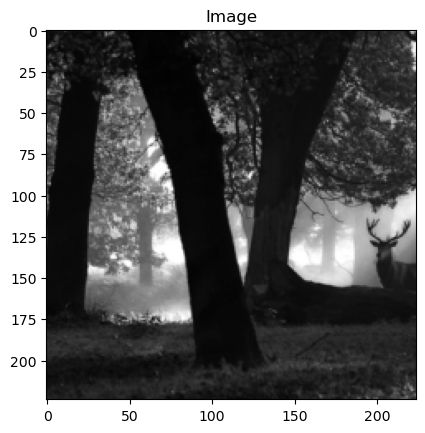

caption:  ['<start>', 'nice', 'capture', 'light', 'quality', 'nice', '<end>']


In [65]:
img, vec, img_id = dataset[8083]
print(img_id)
show_image(img, "Image")

caption = [dataset.vocab.itos[token] for token in vec.tolist()]
print("caption: ", caption)

In [66]:
class Collate_fn:
    def __init__(self, pad_value, batch_first=False):
        self.pad_value = pad_value
        self.batch_first = batch_first
        
    def __call__(self, batch):
        # get all inputs images
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        
        captions = [item[1] for item in batch]
        
        captions = pad_sequence(captions, batch_first = self.batch_first, padding_value = self.pad_value)
        
        img_ids = [item[2] for item in batch]
        
        return imgs, captions, img_ids

In [67]:
batch_size = 10
pad_value = dataset.vocab.stoi["<PAD>"]

In [68]:
validation_split = .8
test_split = .9
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))

val_split = int(np.floor(validation_split * dataset_size))
test_split = int(np.floor(test_split * dataset_size))
train_indices, val_indices, test_indices = indices[:val_split], indices[val_split:test_split], indices[test_split:]

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

In [69]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [70]:
train_loader = torch.utils.data.DataLoader(dataset, 
                                            batch_size=batch_size, shuffle=False,
                                            collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                            sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                batch_size=batch_size,
                                                collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                batch_size=batch_size,
                                                collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                sampler=test_sampler)

nice composition exposure bit contrast may really added punch image


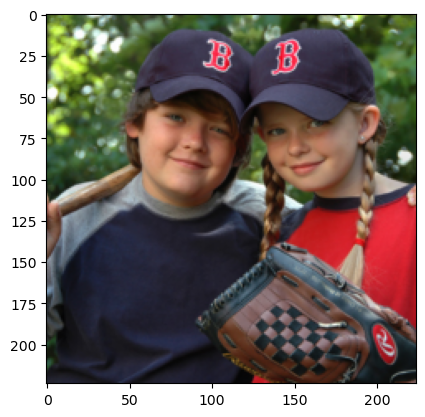

In [71]:
trainItr = iter(train_loader)
batch = next(trainItr)
imgs, captions, img_ids = batch

for i in range(batch_size):
    img, caption = imgs[i], captions[i]

    sentence = [dataset.vocab.itos[token] for token in caption.tolist()]

    end_indx = sentence.index('<end>')

    sentence = sentence[1:end_indx]
    sentence = ' '.join(sentence)

    print(sentence)
    show_image(img)
    plt.show()
    
    break

## Model

In [72]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.resnet152 = resnet
        
    def forward(self, images):
        # images.shape = [bs, 3, 224, 224]
        
        features = self.resnet152(images) 
        # features.shape = [bs, 2048, 7, 7]
        
        features = features.permute(0, 2, 3, 1)
        # features.shape = [bs, 7, 7, 2048]
        
        features = features.view(features.size(0), -1, features.size(-1))
        # features.shape = [bs, 49, 2048]
        
        return features

In [73]:
class Attention(nn.Module):
    
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.attention_dim = attention_dim
        
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
    
    def forward(self, features, hidden_states):
        att1 = self.encoder_att(features)   
        att2 = self.decoder_att(hidden_states)
        combined_states = torch.tanh(att1 + att2.unsqueeze(1))

        attention_scores = self.full_att(combined_states)
        attention_scores = attention_scores.squeeze(2)

        alpha = F.softmax(attention_scores, dim=1)

        weighted_encoding = features * alpha.unsqueeze(2)
        weighted_encoding = weighted_encoding.sum(dim=1)

        return alpha, weighted_encoding

In [74]:
import copy

class Decoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()

        self.vocab_sz = vocab_sz
        self.att_dim = att_dim
        self.dec_dim = dec_dim
        self.embedding = nn.Embedding(vocab_sz, embed_sz)
        self.attention = Attention(enc_dim, dec_dim, att_dim)
        
        self.init_h = nn.Linear(enc_dim, dec_dim)
        self.init_c = nn.Linear(enc_dim, dec_dim)
        
        self.lstm_cell1 = nn.LSTMCell(dec_dim + embed_sz, dec_dim, bias=True)
        self.lstm_cell2 = nn.LSTMCell(enc_dim + dec_dim, dec_dim, bias = True)
        
        self.f_beta = nn.Linear(dec_dim, enc_dim)
        self.fcn = nn.Linear(dec_dim, vocab_sz)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions, teacher):
        cap_len = len(captions[0]) - 1
        
        batch_sz = captions.size(0)
        num_features = features.size(1)
        embeds = self.embedding(captions)

        #h1, c1 = self.init_hidden_state(features)
        h1 = torch.zeros(batch_sz, self.dec_dim).to(device)
        c1 = torch.zeros(batch_sz, self.dec_dim).to(device)
        h2, c2 = h1.clone(), c1.clone()
        
        preds = torch.zeros(batch_sz, cap_len, self.vocab_sz).to(device)
        alphas = torch.zeros(batch_sz, cap_len, num_features).to(device)
        
        for i in range(cap_len):
            # <start> or use teacher forcing according teacher * 100%
            if i == 0 or np.random.rand() < teacher:
                lstm_input1 = torch.cat((h2, embeds[:,i]), dim=1)
                #print(lstm_input.shape)
            else:
                # output 10,23756 -> argmax 10, 1 -> embed 10, 500
                output = [output[j, :].reshape(1, -1).argmax(dim=1).item() for j in range(batch_sz)]
                output = torch.tensor(np.array(output)).to(device)
                output = self.embedding(output)
                lstm_input1 = torch.cat((h2, output), dim=1)
            
            h1, c1 = self.lstm_cell1(lstm_input1, (h1, c1))
            alpha, att_weights = self.attention(features, h1)
            #print(att_weights.shape)
            lstm_input2 = torch.cat((att_weights, h1), dim=1)
            h2, c2 = self.lstm_cell2(lstm_input2, (h2, c2))

            output = self.fcn(self.drop(h2))
            #print(output.shape, h1.shape, c1.shape)

            preds[:, i] = output
            alphas[:, i] = alpha
            
        return preds, alphas
    
    def generate_caption(self, features, max_len=40, vocab=None, K=5):
        batch_sz = features.size(0)
        candidates = []
        final_candidates = []
        
        #h1, c1 = self.init_hidden_state(features)
        h1 = torch.zeros(batch_sz, self.dec_dim).to(device)
        c1 = torch.zeros(batch_sz, self.dec_dim).to(device)
        h2, c2 = h1.clone(), c1.clone()
        
        alphas = []
        captions = [vocab.stoi['<start>']]
        
        word = torch.tensor(vocab.stoi['<start>']).view(1, -1).to(device)
        embeds = self.embedding(word)
        
        # BeamSearch
        lstm_input1 = torch.cat((h2, embeds[:, 0]), dim=1)
        h1, c1 = self.lstm_cell1(lstm_input1, (h1, c1))    
        alpha, weighted_encoding = self.attention(features, h1)
        lstm_input2 = torch.cat((weighted_encoding, h1), dim=1)
        h2, c2 = self.lstm_cell2(lstm_input2, (h2, c2))
        output = self.fcn(self.drop(h2))
        output = output.view(batch_sz, -1)
        output = output.squeeze(dim=0)
        output = F.log_softmax(output, dim=0)
        for i in range(K):
            pred_word_idx = output.argmax(dim=0).item()
            candidates.append([output[pred_word_idx].item(), output[pred_word_idx].item(), (h1, c1, h2, c2), [pred_word_idx]])
            output[pred_word_idx] = -999999
        
        while len(final_candidates) < K:
            new_candidates = []
            for candidate in candidates:
                word = torch.tensor(candidate[3][-1]).view(1,-1).to(device)
                embeds = self.embedding(word)
                h1, c1, h2, c2 = candidate[2]
                lstm_input1 = torch.cat((h2, embeds[:, 0]), dim=1)
                h1, c1 = self.lstm_cell1(lstm_input1, (h1, c1))    
                alpha, weighted_encoding = self.attention(features, h1)
                lstm_input2 = torch.cat((weighted_encoding, h1), dim=1)
                h2, c2 = self.lstm_cell2(lstm_input2, (h2, c2))
                output = self.fcn(self.drop(h2))
                output = output.view(batch_sz, -1)
                output = output.squeeze(dim=0)
                output = F.log_softmax(output, dim=0)

                for j in range(K):
                    pred_word_idx = output.argmax(dim=0).item()
                    new_candidates.append(copy.deepcopy(candidate))
                    new_candidates[-1][1] += output[pred_word_idx].item()
                    new_candidates[-1][2] = (h1, c1, h2, c2)
                    new_candidates[-1][0] = new_candidates[-1][1] / (((5+len(new_candidates[-1][3])) / (5+1)) ** 1.2)
                    #new_candidates[-1][0] = new_candidates[-1][1] / len(new_candidates[-1][3])
                    new_candidates[-1][3] += [pred_word_idx]
                    output[pred_word_idx] = -99999

            new_candidates.sort(key=lambda x:x[0], reverse=True)
            candidates = new_candidates[:K]
            
            for candidate in candidates[::]:
                if vocab.itos[candidate[3][-1]] == '<end>' or len(candidate[3]) > 40:
                    final_candidates.append(candidate)
                    candidates.remove(candidate)
        
        final_candidates.sort(key=lambda x:x[0], reverse=True)
        captions += final_candidates[0][3]
                    
        return [vocab.itos[idx] for idx in captions], None
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        
        return h, c

In [75]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = Encoder()
        
        # encoder freezing
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.decoder = Decoder(
            embed_sz = embed_sz,
            vocab_sz = vocab_sz,
            att_dim = att_dim,
            enc_dim = enc_dim,
            dec_dim = dec_dim
        )
    
    def forward(self, images, captions, teacher):

        features = self.encoder(images)
        outputs = self.decoder(features, captions, teacher)

        return outputs

In [76]:
embed_sz = 100
vocab_sz = len(dataset.vocab)
att_dim = 256
enc_dim = 2048
dec_dim = 512
learning_rate = 0.00005

In [77]:
model = EncoderDecoder(
    embed_sz = 100,
    vocab_sz = len(dataset.vocab),
    att_dim = 128,
    enc_dim = 2048,
    dec_dim = 256
).to(device)

In [78]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])

#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=False)

## Train

In [80]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [81]:
print_each = 100
epochs = 20

C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

<Figure size 640x480 with 0 Axes>

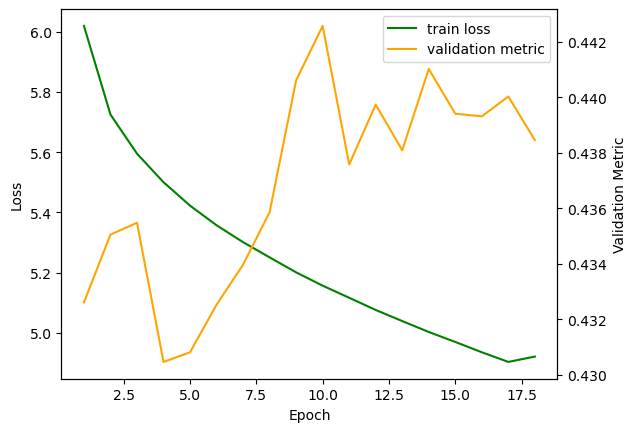

18 epochs : train_loss = 4.921412463639973, validation metric = 0.4384537569068423
BLEU: 0.332181
METEOR: 0.211912
BERT-Score: 0.880750
Rouge-L Score: 0.328972
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

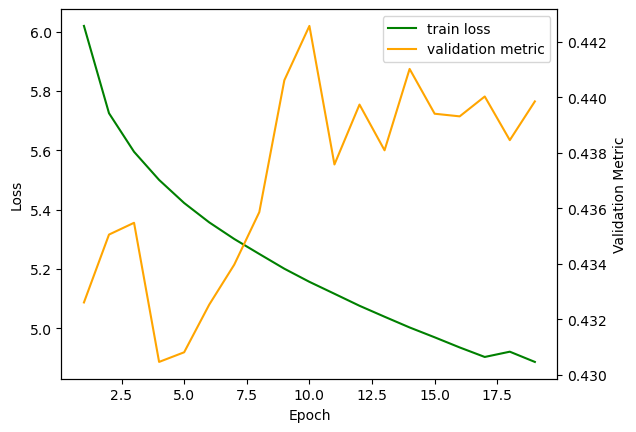

19 epochs : train_loss = 4.886933559344375, validation metric = 0.43984860747889043
BLEU: 0.335485
METEOR: 0.213965
BERT-Score: 0.880496
Rouge-L Score: 0.329448
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

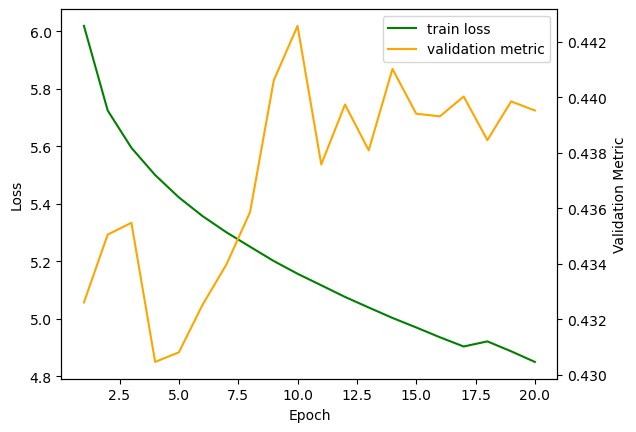

20 epochs : train_loss = 4.849944038425646, validation metric = 0.439521643250951
BLEU: 0.334787
METEOR: 0.213523
BERT-Score: 0.880303
Rouge-L Score: 0.329473
current learning rate : 5e-05


In [82]:
train_loss = []
val_metric = []
highest_val = 0
bertscorer = load("bertscore")
rougescorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

for epoch in range(1, epochs+1):
    model.train()
    train_loss.append(0)
    val_metric.append(0)
    for idx, (img, captions, img_ids) in enumerate(iter(train_loader)):

        img, captions = img.to(device), captions.to(device)
        targets = captions[:, 1:]
        
        optimizer.zero_grad()
        
        pred_caps, attentions = model(img, captions, teacher=max(0, 1 - 0.005 * epoch))
        
        loss = criterion(pred_caps.view(-1, vocab_sz), targets.reshape(-1))
        train_loss[-1] += loss.item() * train_loader.batch_size
        
        loss.backward()
        optimizer.step()
    
    # Validaion calculate
    model.eval()
    bleu, meteor, bert_score, rougescore = 0, 0, 0, 0

    for idxx, (img, captions, img_ids) in enumerate(iter(val_loader)):
        with torch.no_grad():
            for i in range(batch_size):
                if len(captions[i:i+1]) == 0:
                    break
                    
                features = model.encoder(img[i:i+1].to(device))
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
                
                bleu += sentence_bleu(descriptors[img_ids[i]], pred_caps, weights=(1.0, 0, 0, 0))
                meteor += meteor_score(descriptors[img_ids[i]], pred_caps)
                bert_score_tmp, rougescore_tmp = 0, 0
                for j in range(len(descriptors[img_ids[i]])):
                    bert_score_tmp += bertscorer.compute(predictions=[' '.join(pred_caps)], references=[' '.join(descriptors[img_ids[i]][j])], model_type="distilbert-base-uncased")['f1'][0]
                    rougescore_tmp += rougescorer.score(' '.join(pred_caps), ' '.join(descriptors[img_ids[i]][j]))['rougeL'].fmeasure
                bert_score += bert_score_tmp / len(descriptors[img_ids[i]])
                rougescore += rougescore_tmp / len(descriptors[img_ids[i]])
    
    bleu = bleu / len(val_sampler)
    meteor = meteor / len(val_sampler)
    bert_score = bert_score / len(val_sampler)
    rougescore = rougescore / len(val_sampler)
    
    train_loss[-1] = train_loss[-1] / len(train_sampler)
    val_metric[-1] = bleu/4 + meteor/4 + bert_score/4 + rougescore/4
    #scheduler.step(val_metric[-1])
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    line1 = ax1.plot(list(range(1, epoch+1)), train_loss, color = 'green', label='train loss')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Metric')
    line2 = ax2.plot(list(range(1, epoch+1)), val_metric, color = 'orange', label='validation metric')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    plt.show()
    print(str(epoch) + " epochs : train_loss = " + str(train_loss[-1]) + ", validation metric = " + str(val_metric[-1]))
    print('BLEU: %f' % bleu)
    print('METEOR: %f' % (meteor))
    print('BERT-Score: %f' % (bert_score))
    print('Rouge-L Score: %f' % (rougescore))
    print("current learning rate : " + str(optimizer.param_groups[0]['lr']))
    
    # save latest model
    #if highest_val < val_metric[-1]:
    PATH = './weights/IQA_no12_' + str(epoch) + 'epochs.pt'
    torch.save(model.state_dict(), PATH)
    #highest_val = val_metric[-1]

In [ ]:
# PATH = './weights/IQA_no3_11epochs.pt'
# torch.save(model.state_dict(), PATH)

## Test

In [95]:
PATH = './weights/IQA_no12_10epochs.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Original: <start> overly exciting colours rgb like black white <end>
Predicted: <start> nice capture good use bw <end>


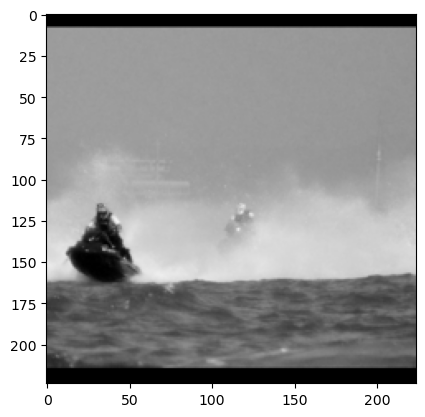

In [162]:
model.eval()
with torch.no_grad():
    itr = iter(val_loader)
    img, captions, img_ids = next(itr)
    
    caption = captions[0:1][0].tolist()
    s = [dataset.vocab.itos[idx] for idx in caption if idx != 0]
    print("Original:", ' '.join(s))
    
    features = model.encoder(img[0:1].to(device))

    pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

    caption = ' '.join(pred_caps)
    print("Predicted:", caption)
    show_image(img[0])

In [85]:
bertscorer = load("bertscore")
rougescorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def evaluateModel(model, dls):
    model.eval()
    bleu, meteor, bert_score, rougescore = 0, 0, 0, 0
    
    for idxx, (img, captions, img_ids) in enumerate(iter(dls)):
        print(idxx)
        with torch.no_grad():
            
            for i in range(batch_size):
                if len(captions[i:i+1]) == 0:
                    break
                    
                features = model.encoder(img[i:i+1].to(device))
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

                bleu += sentence_bleu(descriptors[img_ids[i]], pred_caps, weights=(1.0, 0, 0, 0))
                meteor += meteor_score(descriptors[img_ids[i]], pred_caps)
                bert_score_tmp, rougescore_tmp = 0, 0
                for j in range(len(descriptors[img_ids[i]])):
                    bert_score_tmp += bertscorer.compute(predictions=[' '.join(pred_caps)], references=[' '.join(descriptors[img_ids[i]][j])], model_type="distilbert-base-uncased")['f1'][0]
                    rougescore_tmp += rougescorer.score(' '.join(pred_caps), ' '.join(descriptors[img_ids[i]][j]))['rougeL'].fmeasure
                bert_score += bert_score_tmp / len(descriptors[img_ids[i]])
                rougescore += rougescore_tmp / len(descriptors[img_ids[i]])
    
    print('BLEU: %f' % (bleu / len(val_sampler)))
    print('METEOR: %f' % (meteor / len(test_sampler)))
    print('BERT-Score: %f' % (bert_score / len(test_sampler)))
    print('Rouge-L Score: %f' % (rougescore / len(test_sampler)))

In [86]:
evaluateModel(model, test_loader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27